In [1]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose, LeakyReLU, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from matplotlib import pyplot as plt
import imageio, glob

2021-08-06 12:15:12.795544: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
npzfile1 = np.load('/gpfs/alpine/gen150/scratch/arjun2612/ORNL_Coding/Code/sars_mers_cov2_dataset/smc2_dataset.npz')
smc2_trainset = npzfile1['train4D']
smc2_valset = npzfile1['val4D']
smc2_lt_onehot = npzfile1['ltoh']
smc2_lv_onehot = npzfile1['lvoh']
smc2_label_validation = npzfile1['labval']

In [3]:
npzfile2 = np.load('/gpfs/alpine/gen150/scratch/arjun2612/ORNL_Coding/Code/hea_dataset/hea_dataset.npz')
hea_trainset = npzfile2['train4D']
hea_valset = npzfile2['val4D']
hea_lt_onehot = npzfile2['ltoh']
hea_lv_onehot = npzfile2['lvoh']
hea_label_validation = npzfile2['labval']

In [4]:
generator = Sequential()

generator.add(Conv2DTranspose(128, (3, 3), padding='same', input_shape=(24, 24, 1), activation=LeakyReLU())) # batch_size x 24 x 24 x 128
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, (3, 3), padding='same', activation=LeakyReLU())) # batch_size x 24 x 24 x 64
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, (3, 3), padding='same', activation='tanh')) # batch_size x 24 x 24 x 1

2021-08-06 12:15:15.163072: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-06 12:15:15.163913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-06 12:15:15.199486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-06 12:15:15.199518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-06 12:15:15.201732: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-06 12:15:15.201799: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 24, 24, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 24, 24, 1)         577       
Total params: 76,417
Trainable params: 76,033
Non-trainable params: 384
_________________________________________________________________


2021-08-06 12:15:15.949992: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-08-06 12:15:17.193296: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-06 12:15:17.480762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


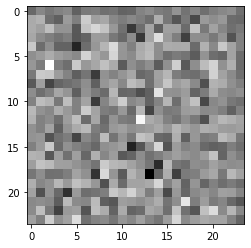

In [6]:
noise = tf.random.normal([1, 24, 24, 1])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray') # generate some noise to test the generator

In [7]:
discriminator = Sequential()
discriminator.add(Conv2D(64, (3, 3), padding='same', input_shape=(24, 24, 1), activation=LeakyReLU()))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU()))
discriminator.add(Dropout(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1))

In [8]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        640       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73729     
Total params: 148,225
Trainable params: 148,225
Non-trainable params: 0
________________________________________________

In [9]:
decision = discriminator(generated_image)
print(decision) # test out discriminator. Outputs positive values for real and negative values for fake images

tf.Tensor([[-0.01401972]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
epochs = 20
noise_dim = 24
examples_generated = 20
batch_size = 100

seed = tf.random.normal([examples_generated, noise_dim])
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim, noise_dim, 1])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset):
    count = 0
    for input_batch in range(int(len(dataset) / batch_size)):
        train_step(dataset[count:count + batch_size])
        count = count + batch_size

In [15]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    for i in range(epochs):
        fig = plt.figure(i)
        plt.subplot(4, 5, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

        plt.savefig('cmaps/image_at_epoch_{:04d}.png'.format(i))
    plt.show()

In [16]:
print(smc2_trainset.shape)
train(smc2_trainset)

(60000, 24, 24, 1)


2021-08-06 12:15:20.136302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-06 12:15:20.145327: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


2021-08-06 12:15:27.312381: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2021-08-06 12:15:27.706790: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-06 12:15:27.707169: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-06 12:15:27.707417: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran

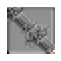

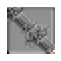

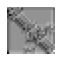

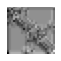

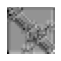

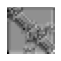

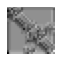

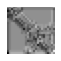

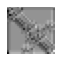

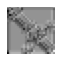

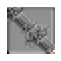

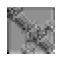

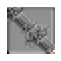

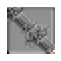

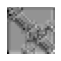

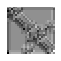

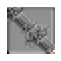

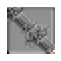

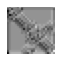

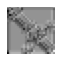

In [17]:
generate_and_save_images(generator, epochs, smc2_valset)

In [18]:
anim_file = 'dcgan.gif'
filenames = glob.glob('cmaps/image*.png')
filenames = sorted(filenames)
images = []
for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)
imageio.mimsave(anim_file, images, fps=2)